In [1]:
from keras.datasets import mnist
from keras import layers
from keras import models
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import math   
import os
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os_path = './drive/MyDrive/data/training/'

In [4]:
len(os.listdir(os_path))

11086

In [4]:
list_of_names = os.listdir(os_path)
jpgs = []
for each in list_of_names:
  if(".jpg" in each):
    jpgs.append(each)
len(jpgs)

5543

In [5]:
train_jpgs, valid_jpgs_T= train_test_split(jpgs, test_size=0.2)
valid_jpgs, test_jpgs = train_test_split(valid_jpgs_T, test_size=0.5)
print(len(train_jpgs),len(valid_jpgs),len(test_jpgs))

4434 554 555


In [6]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [7]:
labels = {}
for each in jpgs:
  pose = get_ypr_from_mat(os_path+each[:-4])
  pitch, yaw, roll = pose[0] * 180 / np.pi, pose[1] * 180 / np.pi, pose[2] * 180 / np.pi
  bins = np.array(range(-99, 102, 3))
  binned_pose = np.digitize([yaw, pitch, roll], bins) - 1
  real_labels = [yaw, pitch, roll]
  labels[each] = (binned_pose,real_labels)

In [8]:
train_y, valid_y, test_y = [], [], []
for each in train_jpgs:
  train_y.append(labels[each][0])
for each in valid_jpgs:
  valid_y.append(labels[each][0])
for each in test_jpgs:
  test_y.append(labels[each][0])
print(len(train_jpgs), len(train_y), len(valid_jpgs), len(valid_y), len(test_jpgs), len(test_y))

4434 4434 554 554 555 555


In [9]:
def loadImages(image_dataset_names):
    images = []
    for i, img_name in enumerate(image_dataset_names):
        img = cv2.imread(os_path+img_name)
        img = cv2.resize(img, (240,240))
        # img= np.array(Image.open(os_path+img_name))
        img = np.array(img)
        img = img.astype('float32')
        img /= 255 
        images.append(img)
    return images

train_images = loadImages(train_jpgs)
val_images = loadImages(valid_jpgs)
#test_images = loadImages(test_jpgs)

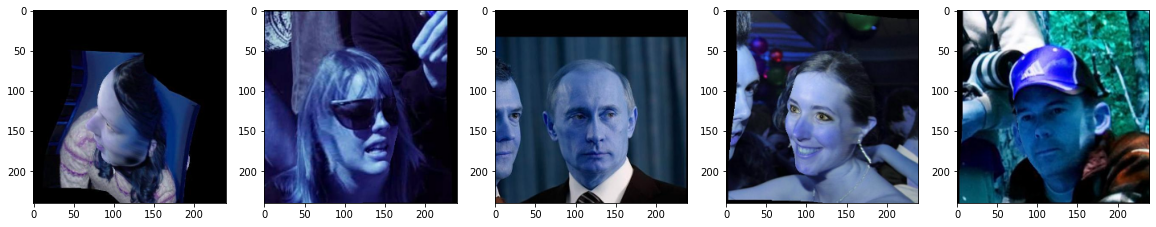

In [10]:
plt.figure(figsize=(20,20))
for i in range(5):
    ax=plt.subplot(1,5,i+1)
    plt.imshow(train_images[i])

In [11]:
t0 = tf.keras.utils.to_categorical(np.array(train_y)[:,0],66)
t1 = tf.keras.utils.to_categorical(np.array(train_y)[:,1],66)
t2 = tf.keras.utils.to_categorical(np.array(train_y)[:,2],66)

v0 = tf.keras.utils.to_categorical(np.array(valid_y)[:,0],66)
v1 = tf.keras.utils.to_categorical(np.array(valid_y)[:,1],66)
v2 = tf.keras.utils.to_categorical(np.array(valid_y)[:,2],66)

In [13]:
inputs = tf.keras.layers.Input(shape=(240, 240, 3))
        
tensor = tf.keras.layers.Conv2D(filters=64, kernel_size=(11, 11), strides=4, padding='same', activation=tf.nn.relu)(inputs)
tensor = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(tensor)
tensor = tf.keras.layers.Conv2D(filters=192, kernel_size=(5, 5), padding='same', activation=tf.nn.relu)(tensor)
tensor = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(tensor)
tensor = tf.keras.layers.BatchNormalization()(tensor)
tensor = tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = tf.keras.layers.BatchNormalization()(tensor)
tensor = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(tensor)
tensor = tf.keras.layers.BatchNormalization()(tensor)
tensor = tf.keras.layers.Flatten()(tensor)
tensor = tf.keras.layers.Dropout(0.5)(tensor)
tensor = tf.keras.layers.Dense(units=4096, activation=tf.nn.relu)(tensor)

fc_yaw = tf.keras.layers.Dense(name='yaw', units=66,activation='softmax')(tensor)
model = tf.keras.Model(inputs=inputs, outputs=fc_yaw)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [ ]:
history1 = model.fit(np.array(train_images), t0, epochs=90, batch_size=10, validation_data=(np.array(val_images), v0))

Epoch 1/90
444/444 [==============================] - 15s 32ms/step - loss: 4.8203 - accuracy: 0.0582 - val_loss: 3.4847 - val_accuracy: 0.0740
Epoch 2/90
444/444 [==============================] - 14s 31ms/step - loss: 2.9226 - accuracy: 0.1216 - val_loss: 2.9225 - val_accuracy: 0.1354
Epoch 3/90
444/444 [==============================] - 14s 31ms/step - loss: 2.6255 - accuracy: 0.1617 - val_loss: 5.0934 - val_accuracy: 0.0776
Epoch 4/90
444/444 [==============================] - 14s 31ms/step - loss: 2.4635 - accuracy: 0.1813 - val_loss: 2.4649 - val_accuracy: 0.1715
Epoch 5/90
444/444 [==============================] - 14s 31ms/step - loss: 2.2998 - accuracy: 0.2091 - val_loss: 2.4170 - val_accuracy: 0.2022
Epoch 6/90
444/444 [==============================] - 14s 31ms/step - loss: 2.2094 - accuracy: 0.2201 - val_loss: 2.2754 - val_accuracy: 0.2256
Epoch 7/90
444/444 [==============================] - 14s 31ms/step - loss: 2.0493 - accuracy: 0.2373 - val_loss: 2.2179 - val_accuracy:

In [ ]:
# accuracy as a function of epochs
def plot_accu_v_epoch(model_history):
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val acuuracy'], loc='upper right')
  plt.show()
def plot_loss_v_epoch(model_history):
  plt.plot(model_history.history['val_loss'])
  plt.plot(model_history.history['loss'])
  plt.title('model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['val loss', 'loss'], loc='upper right')
  plt.show()

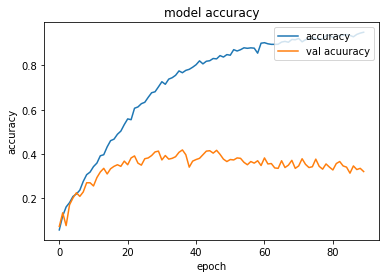

In [ ]:
plot_accu_v_epoch(history1) 

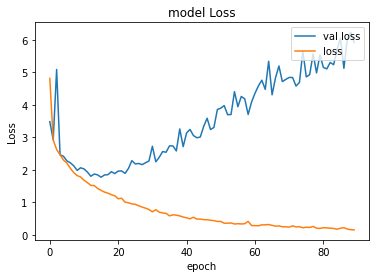

In [ ]:
plot_loss_v_epoch(history1)  

#Combining losses of y,p,r
>Model-2

In [11]:
inputs = layers.Input(shape=(240, 240, 3))
        
tensor = layers.Conv2D(filters=64, kernel_size=(11, 11), strides=4, padding='same', activation=tf.nn.relu)(inputs)
tensor = layers.MaxPool2D(pool_size=(3, 3), strides=2)(tensor)
tensor = layers.Conv2D(filters=192, kernel_size=(5, 5), padding='same', activation=tf.nn.relu)(tensor)
tensor = layers.MaxPool2D(pool_size=(3, 3), strides=2)(tensor)
tensor = layers.BatchNormalization()(tensor)
tensor = layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = layers.BatchNormalization()(tensor)
tensor = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(tensor)
tensor = layers.MaxPool2D(pool_size=(3, 3), strides=2)(tensor)
tensor = layers.BatchNormalization()(tensor)
tensor = layers.Flatten()(tensor)
tensor = layers.Dropout(0.5)(tensor)
tensor = layers.Dense(units=4096, activation=tf.nn.relu)(tensor)

fc_yaw = layers.Dense(name='yaw', units=66,activation='softmax')(tensor)
fc_pitch = layers.Dense(name='pitch', units=66,activation='softmax')(tensor)
fc_roll = layers.Dense(name='roll', units=66,activation='softmax')(tensor)
model1 = tf.keras.Model(inputs=inputs, outputs=[fc_yaw, fc_pitch, fc_roll])
model1.compile(optimizer='adam',loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],loss_weights=[1, 0.3, 0.3],metrics='accuracy')

In [20]:
history1 = model1.fit(np.array(train_images), [t0,t1,t2], epochs=50, batch_size=10, validation_data=(np.array(val_images), [v0,v1,v2]))

Epoch 1/50
444/444 [==============================] - 31s 45ms/step - loss: 6.3737 - yaw_loss: 4.4969 - pitch_loss: 3.2597 - roll_loss: 2.9965 - yaw_accuracy: 0.0544 - pitch_accuracy: 0.1198 - roll_accuracy: 0.1319 - val_loss: 4.6563 - val_yaw_loss: 3.0174 - val_pitch_loss: 2.8327 - val_roll_loss: 2.6303 - val_yaw_accuracy: 0.0903 - val_pitch_accuracy: 0.1047 - val_roll_accuracy: 0.1679
Epoch 2/50
444/444 [==============================] - 19s 42ms/step - loss: 4.3864 - yaw_loss: 2.7517 - pitch_loss: 2.8533 - roll_loss: 2.5959 - yaw_accuracy: 0.1261 - pitch_accuracy: 0.1371 - roll_accuracy: 0.1585 - val_loss: 4.1882 - val_yaw_loss: 2.5774 - val_pitch_loss: 2.7819 - val_roll_loss: 2.5877 - val_yaw_accuracy: 0.1426 - val_pitch_accuracy: 0.1480 - val_roll_accuracy: 0.1895
Epoch 3/50
444/444 [==============================] - 19s 42ms/step - loss: 3.9118 - yaw_loss: 2.3554 - pitch_loss: 2.7623 - roll_loss: 2.4257 - yaw_accuracy: 0.1633 - pitch_accuracy: 0.1371 - roll_accuracy: 0.1912 - val

In [102]:
val =model1.predict(np.array(test_images))
np.array(val)[0].shape

(555, 66)

In [23]:
from math import cos, sin
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [13]:
# accuracy as a function of epochs
grphs = ['yaw','pitch', 'roll']
def plot_accu_v_epoch_mul(model_history):
  plt.figure(figsize=(12,12))
  for i in range(3):
    ax=plt.subplot(3,3,i+1)
    plt.plot(model_history.history[grphs[i]+'_accuracy'])
    plt.plot(model_history.history['val_'+grphs[i]+'_accuracy'])
    plt.title(grphs[i]+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val acuuracy'], loc='upper right')
  plt.show()

def plot_loss_v_epoch_mul(model_history):
  plt.figure(figsize=(12,12))
  for i in range(3):
    ax=plt.subplot(3,3,i+1)
    plt.plot(model_history.history[grphs[i]+'_loss'])
    plt.plot(model_history.history['val_'+grphs[i]+'_loss'])
    plt.title(grphs[i]+' model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['val loss', 'loss'], loc='upper right')
  plt.show()

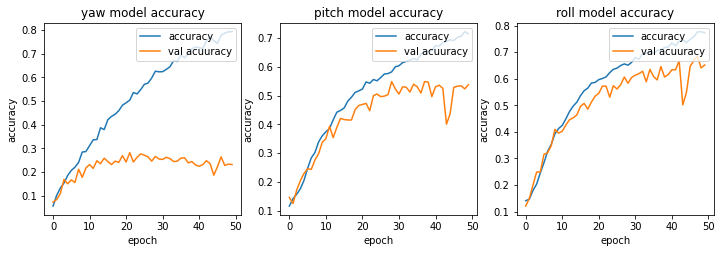

In [ ]:
plot_accu_v_epoch_mul(history1)

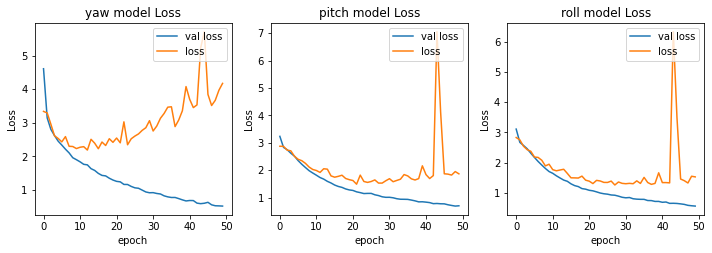

In [ ]:
plot_loss_v_epoch_mul(history1)

# Changing input image by croping the image
> Model 3

In [7]:
labels = {}
for each in jpgs:
  xys = get_pt2d_from_mat(os_path+each[:-4])
  pose = get_ypr_from_mat(os_path+each[:-4])
  pitch, yaw, roll = pose[0] * 180 / np.pi, pose[1] * 180 / np.pi, pose[2] * 180 / np.pi
  bins = np.array(range(-99, 102, 3))
  binned_pose = np.digitize([yaw, pitch, roll], bins) - 1
  real_labels = np.float32(np.array([yaw, pitch, roll]))
  labels[each] = (binned_pose,real_labels,xys)

In [9]:
def loadImages(image_dataset_names):
    images = []
    for i, img_name in enumerate(image_dataset_names):
        img = cv2.imread(os_path+img_name)
        pt2d = labels[img_name][2]
        # Crop the face loosely
        x_min = min(pt2d[0, :])
        y_min = min(pt2d[1, :])
        x_max = max(pt2d[0, :])
        y_max = max(pt2d[1, :])

        Lx = abs(x_max - x_min)
        Ly = abs(y_max - y_min)
        Lmax = max(Lx, Ly) * 1.5
        center_x = x_min + Lx // 2
        center_y = y_min + Ly // 2

        x_min = center_x - Lmax // 2
        x_max = center_x + Lmax // 2
        y_min = center_y - Lmax // 2
        y_max = center_y + Lmax // 2

        if x_min < 0:
            y_max -= abs(x_min)
            x_min = 0
        if y_min < 0:
            x_max -= abs(y_min)
            y_min = 0
        if x_max > img.shape[1]:
            y_min += abs(x_max - img.shape[1])
            x_max = img.shape[1]
        if y_max > img.shape[0]:
            x_min += abs(y_max - img.shape[0])
            y_max = img.shape[0]

        # print("x_min:{},x_max:{},y_min:{},y_max{}".format(x_min, x_max, y_min, y_max))
        crop_img = img[int(y_min):int(y_max), int(x_min):int(x_max)]

        # print(crop_img.shape)
        # cv2.imshow('crop_img', crop_img)
        # cv2.waitKey(0)
        crop_img = np.asarray(cv2.resize(crop_img, (240,240)))
        normed_img = (crop_img - crop_img.mean()) / crop_img.std()
        images.append(normed_img)
    return images

train_images = loadImages(train_jpgs)
val_images = loadImages(valid_jpgs)

In [10]:
t0 = tf.keras.utils.to_categorical(np.array(train_y)[:,0],66)
t1 = tf.keras.utils.to_categorical(np.array(train_y)[:,1],66)
t2 = tf.keras.utils.to_categorical(np.array(train_y)[:,2],66)

v0 = tf.keras.utils.to_categorical(np.array(valid_y)[:,0],66)
v1 = tf.keras.utils.to_categorical(np.array(valid_y)[:,1],66)
v2 = tf.keras.utils.to_categorical(np.array(valid_y)[:,2],66)

In [ ]:
type(labels['AFW_82161078_1_11.jpg'][1][0])

numpy.float32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


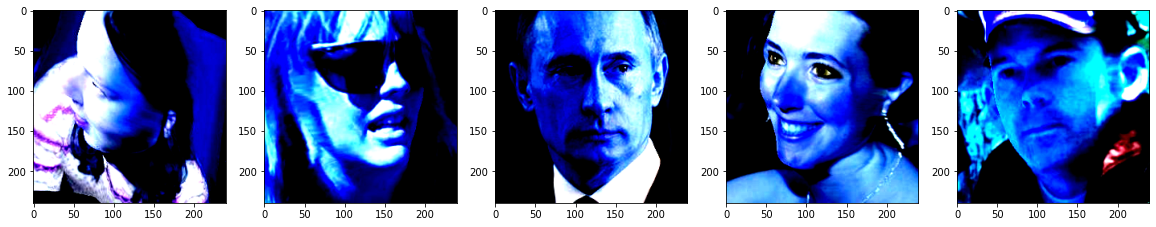

In [17]:
plt.figure(figsize=(20,20))
for i in range(5):
    ax=plt.subplot(1,5,i+1)
    plt.imshow(train_images[i])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 64)        23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 192)       307392    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 192)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 192)      768   

In [ ]:
history2 = model.fit(np.array(train_images), t0, epochs=70, batch_size=10, validation_data=(np.array(val_images), v0))

Epoch 1/70
444/444 [==============================] - 22s 24ms/step - loss: 4.7231 - accuracy: 0.0485 - val_loss: 3.2113 - val_accuracy: 0.1029
Epoch 2/70
444/444 [==============================] - 9s 21ms/step - loss: 2.7207 - accuracy: 0.1279 - val_loss: 2.5641 - val_accuracy: 0.1444
Epoch 3/70
444/444 [==============================] - 9s 21ms/step - loss: 2.3725 - accuracy: 0.1590 - val_loss: 2.4099 - val_accuracy: 0.1661
Epoch 4/70
444/444 [==============================] - 9s 21ms/step - loss: 2.1455 - accuracy: 0.2025 - val_loss: 2.1971 - val_accuracy: 0.1949
Epoch 5/70
444/444 [==============================] - 9s 21ms/step - loss: 2.0289 - accuracy: 0.2285 - val_loss: 2.0713 - val_accuracy: 0.2130
Epoch 6/70
444/444 [==============================] - 10s 21ms/step - loss: 1.8885 - accuracy: 0.2664 - val_loss: 1.9312 - val_accuracy: 0.2238
Epoch 7/70
444/444 [==============================] - 9s 21ms/step - loss: 1.7920 - accuracy: 0.2821 - val_loss: 1.8808 - val_accuracy: 0.26

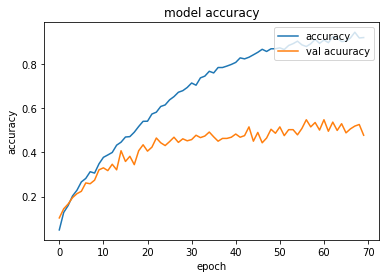

In [ ]:
plot_accu_v_epoch(history2)

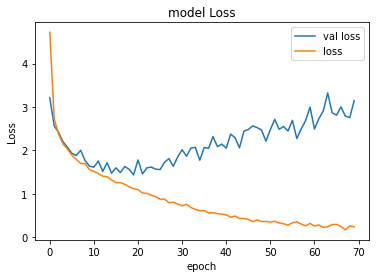

In [ ]:
plot_loss_v_epoch(history2)

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 60, 60, 64)   23296       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 29, 29, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 29, 29, 192)  307392      ['max_pooling2d[0][0]']      

In [12]:
history3 = model1.fit(np.array(train_images), [t0,t1,t2], epochs=50, batch_size=10, validation_data=(np.array(val_images), [v0,v1,v2]))

Epoch 1/50
444/444 [==============================] - 31s 46ms/step - loss: 6.1376 - yaw_loss: 4.2950 - pitch_loss: 3.1631 - roll_loss: 2.9789 - yaw_accuracy: 0.0562 - pitch_accuracy: 0.1234 - roll_accuracy: 0.1473 - val_loss: 4.7812 - val_yaw_loss: 3.1272 - val_pitch_loss: 2.8744 - val_roll_loss: 2.6389 - val_yaw_accuracy: 0.0866 - val_pitch_accuracy: 0.1029 - val_roll_accuracy: 0.1498
Epoch 2/50
444/444 [==============================] - 19s 43ms/step - loss: 4.3662 - yaw_loss: 2.7170 - pitch_loss: 2.8507 - roll_loss: 2.6467 - yaw_accuracy: 0.1265 - pitch_accuracy: 0.1335 - roll_accuracy: 0.1466 - val_loss: 4.1434 - val_yaw_loss: 2.5083 - val_pitch_loss: 2.8109 - val_roll_loss: 2.6396 - val_yaw_accuracy: 0.1552 - val_pitch_accuracy: 0.1480 - val_roll_accuracy: 0.1588
Epoch 3/50
444/444 [==============================] - 19s 43ms/step - loss: 3.9462 - yaw_loss: 2.3540 - pitch_loss: 2.7556 - roll_loss: 2.5518 - yaw_accuracy: 0.1725 - pitch_accuracy: 0.1484 - roll_accuracy: 0.1782 - val

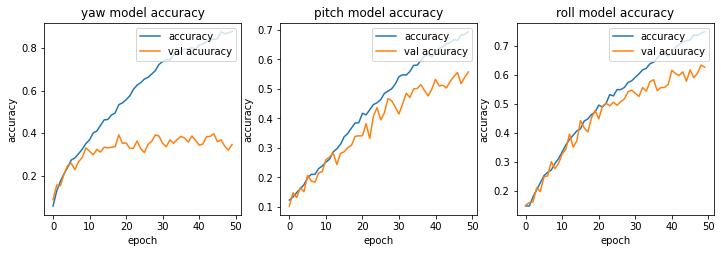

In [14]:
plot_accu_v_epoch_mul(history3)

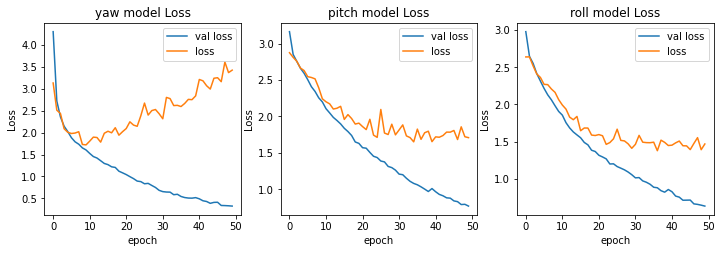

In [15]:
plot_loss_v_epoch_mul(history3)

In [13]:
# with equal loss weights
history3 = model1.fit(np.array(train_images), [t0,t1,t2], epochs=50, batch_size=10, validation_data=(np.array(val_images), [v0,v1,v2]))

Epoch 1/50
444/444 [==============================] - 31s 45ms/step - loss: 10.6005 - yaw_loss: 4.2668 - pitch_loss: 3.3225 - roll_loss: 3.0111 - yaw_accuracy: 0.0410 - pitch_accuracy: 0.1707 - roll_accuracy: 0.2091 - val_loss: 8.6872 - val_yaw_loss: 3.5766 - val_pitch_loss: 2.7783 - val_roll_loss: 2.3323 - val_yaw_accuracy: 0.0596 - val_pitch_accuracy: 0.1733 - val_roll_accuracy: 0.2202
Epoch 2/50
444/444 [==============================] - 19s 42ms/step - loss: 7.8355 - yaw_loss: 3.2520 - pitch_loss: 2.4233 - roll_loss: 2.1603 - yaw_accuracy: 0.0819 - pitch_accuracy: 0.2603 - roll_accuracy: 0.2885 - val_loss: 7.5804 - val_yaw_loss: 3.1644 - val_pitch_loss: 2.3554 - val_roll_loss: 2.0606 - val_yaw_accuracy: 0.0740 - val_pitch_accuracy: 0.2906 - val_roll_accuracy: 0.3159
Epoch 3/50
444/444 [==============================] - 19s 43ms/step - loss: 6.7611 - yaw_loss: 2.9483 - pitch_loss: 2.0135 - roll_loss: 1.7993 - yaw_accuracy: 0.1040 - pitch_accuracy: 0.3493 - roll_accuracy: 0.4046 - va

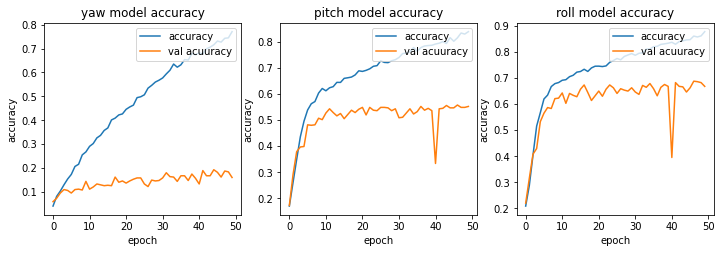

In [17]:
plot_accu_v_epoch_mul(history3)

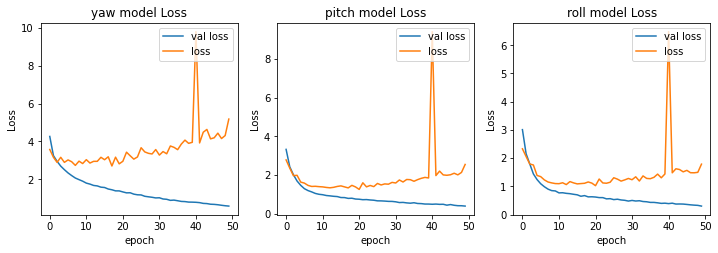

In [16]:
plot_loss_v_epoch_mul(history3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


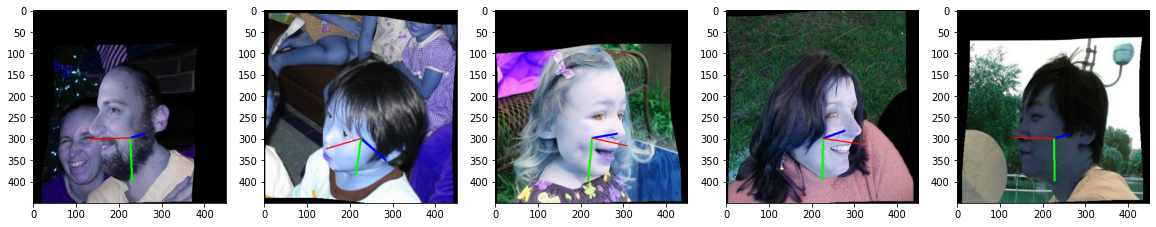

In [25]:
%time
def plot_test(model):
  plt.figure(figsize=(20,20))
  for i in range(5):
      ax=plt.subplot(1,5,i+1)
      val =model.predict(np.array([test_images[i]]))
      
      pt2d = get_pt2d_from_mat(os_path+test_jpgs[i][:-4])      
      x_min = min(pt2d[0, :])
      y_min = min(pt2d[1, :])
      x_max = max(pt2d[0, :])
      y_max = max(pt2d[1, :])

      Lx = abs(x_max - x_min)
      Ly = abs(y_max - y_min)
      Lmax = max(Lx, Ly) * 1.5
      center_x = x_min + Lx // 2
      center_y = y_min + Ly // 2

      predictions = np.asarray(val)
      pred_cont_yaw = bins[np.argmax(val[0])]
      pred_cont_pitch = bins[np.argmax(val[1])]
      pred_cont_roll = bins[np.argmax(val[2])]
      cv2_img = cv2.imread(os_path+test_jpgs[i])
      cv2_img = draw_axis(cv2_img, pred_cont_yaw, pred_cont_pitch, pred_cont_roll, tdx=center_x, tdy=center_y,size=100)
      plt.imshow(cv2_img)
plot_test(model1)

In [18]:
test_images = loadImages(test_jpgs)

In [26]:
idx_tensor = [idx for idx in range(66)]
idx_tensor = tf.Variable(np.array(idx_tensor, dtype=np.float32))
yaw_ground_truth, pitch_ground_truth, roll_ground_truth = [], [], []
for i, each in enumerate(test_jpgs):
  gt_yaw, gt_pitch, gt_roll = get_ypr_from_mat(os_path+test_jpgs[i][:-4])
  yaw_ground_truth.append(gt_yaw)
  pitch_ground_truth.append(gt_pitch)
  roll_ground_truth.append(gt_roll)
val =model1.predict(np.array(test_images))
predictions = np.asarray(val)
pred_cont_yaw = [np.argmax(each) for each in np.array(val)[0]]
pred_cont_pitch = [np.argmax(each) for each in np.array(val)[1]]
pred_cont_roll = [np.argmax(each) for each in np.array(val)[2]]
from sklearn.metrics import mean_absolute_error as mae
mae_yaw = mae(pred_cont_yaw,yaw_ground_truth)
mae_pitch = mae(pred_cont_pitch,pitch_ground_truth)
mae_roll = mae(pred_cont_roll,roll_ground_truth)
print(mae_yaw)
print(mae_pitch)
print(mae_roll)
mae_c = (mae_yaw+mae_pitch+mae_roll)/3
print("MAE combined = ",mae_c)

31.11739392743724
30.057766290352276
32.32045502103953
MAE combined =  31.16520507960968
